In [ ]:
!pip install datasets

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from PIL import ImageOps
from PIL import ImageEnhance
import random
from enum import Enum
import os
from PIL import Image
from textwrap import wrap
from datasets import load_dataset

mydata = load_dataset('valhalla/emoji-dataset')

In [2]:
keywords = ['face','christmas','superhero','supervillian','mage','vampire','monkey','elf','juggling',
            'boy','girl','adult','person','man','woman','male','female','worker','scientist','technologist',
            'singer','artist','pilot','astronaut','firefighter','police','sleuth','construction']


plt.rcParams["figure.figsize"] = [1.5, 1.50]

print(len(mydata['train']))
total_obs = len(mydata['train'])
data = np.zeros([total_obs,3,64,64],dtype='float32')
subset_data = []

class Label(Enum):
    HUMAN = 0
    HUMANOID = 1
    ANIMAL = 2
    INANIMATE = 3
    NORMAL = 4

unfiltered_labels = []
unfiltered_data = []

# Labels

for i in range(total_obs):
    im = mydata['train'][i]['image']
    title = mydata['train'][i]['text']
    if title.find(keywords[0]) > -1:

        label = Label.NORMAL
        if (title.find("clock") !=-1 or title.find("robot") !=-1):
            label = Label.INANIMATE
        elif ((title.find("cat face") !=-1 and i != 641) or (i>=1074 and i<=1098)):
            label = Label.HUMANOID
        elif (i>=631 and i<=712 and i!=668):
            label = Label.ANIMAL
        elif(title.find("massage") !=-1 or title.find("pouting") !=-1 or title.find("gesture") !=-1 or title.find("palm") != -1):
            label = Label.HUMAN

        unfiltered_labels.append(label.value)

        im = im.resize((64,64),Image.LANCZOS)
        # im = np.transpose(im, (2, 0, 1))
        unfiltered_data.append(im)

unfiltered_data = np.array(unfiltered_data)
unfiltered_labels = np.array(unfiltered_labels)

# Test, train, validation split
X_train, X_, y_train, y_  = train_test_split(unfiltered_data, unfiltered_labels, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_, y_, test_size=0.5, random_state=42)

        
# Augmentation
X_train_aug, y_train_aug = [], []
X_val_aug, y_val_aug = [], []
X_test_aug, y_test_aug = [], []

for (collection, labels, X_aug, y_aug) in zip(
    [X_train, X_val, X_test],
    [y_train, y_val, y_test],
    [X_train_aug, X_val_aug, X_test_aug],
    [y_train_aug, y_val_aug, y_test_aug]
):
    for im, label in zip(collection, labels):
        im = Image.fromarray(im)

        # identity, flip, rotate, brighten, and darken
        p1 = im
        p2 = ImageOps.flip(im)
        p3 = im.rotate(random.uniform(-45, 45), fillcolor='white')
        brightness = ImageEnhance.Brightness(im)
        p4 = brightness.enhance(random.uniform(1.2, 1.5))
        p5 = brightness.enhance(random.uniform(0.5, 0.8))
        aug_images = [p1, p2, p3, p4, p5]

        for image in aug_images:
            img_array = np.asarray(image).astype('float32') / 255.0
            X_aug.append(img_array)
            y_aug.append(label)

X_train = np.array(X_train_aug)
X_train = np.transpose(X_train, (0, 3, 2, 1))
y_train = np.array(y_train_aug)
X_val = np.array(X_val_aug)
X_val = np.transpose(X_val, (0, 3, 2, 1))
y_val = np.array(y_val_aug)
X_test = np.array(X_test_aug)
X_test = np.transpose(X_test, (0, 3, 2, 1))
y_test = np.array(y_test_aug)


print("Train size: ", X_train.shape, y_train.shape)
print("Validation size: ", X_val.shape, y_val.shape)
print("Test size: ", X_test.shape, y_test.shape)

2749
Train size:  (610, 3, 64, 64) (610,)
Validation size:  (205, 3, 64, 64) (205,)
Test size:  (205, 3, 64, 64) (205,)


In [3]:
print(X_train.shape, y_train.shape)

(610, 3, 64, 64) (610,)


In [4]:
train_data = torch.tensor(X_train, dtype=torch.float32)
test_data = torch.tensor(X_test, dtype=torch.float32)
valid_data = torch.tensor(X_val, dtype=torch.float32)

train_label = torch.tensor(y_train, dtype=torch.int64)
test_label = torch.tensor(y_test, dtype=torch.int64)
valid_label = torch.tensor(y_val, dtype=torch.int64)

train_dataset = TensorDataset(train_data, train_label)
valid_dataset = TensorDataset(valid_data, valid_label)
test_dataset = TensorDataset(test_data, test_label)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=204, shuffle=True)

In [49]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.z = 0
    self.latent_dim = 256
    self.classify_loss = nn.CrossEntropyLoss()
    
    self.encode = nn.Sequential(
      nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(256 * 4 * 4, self.latent_dim),
    )

    self.decode = nn.Sequential(
      nn.Linear(self.latent_dim, 256 * 4 * 4),
      nn.Unflatten(-1, (256, 4, 4)),
      nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
      nn.ReLU(),
      nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
      nn.ReLU(),
      nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
      nn.ReLU(),
      nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
      nn.Sigmoid()
    )

    self.classify = nn.Linear(self.latent_dim, 5) # 5 labels
  
  def forward(self, x):
    z = self.encode(x)
    out = self.decode(z)
    logits = self.classify(z)
    return out, logits

def train(dataloader, model, loss_func, optimizer, epoch, classify=False):
  model.train()
  size = len(dataloader.dataset)
  train_loss = 0
  i = 0

  for batch, (images, labels) in enumerate(dataloader):
    # make some predictions and get the error    
    output, pred = model(images)

    # print(output.shape, images.shape)
    # print(pred.shape, labels.shape)
    loss = loss_func(output, images)
    if(classify):
        loss += model.classify_loss(pred, labels)
        y_true = Label(labels[0].item())
        y_pred = Label(torch.argmax(pred[0]).item())

    # where the magic happens
    # backpropogation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if(not i and epoch % 5 == 0):
      image = np.transpose(images[0].numpy(), (2, 1, 0))
      image = (image * 255).astype(np.uint8)
      image = Image.fromarray(image)
      plt.imshow(image)
      print("Before: ")
      if(classify):
        print(y_true.name)
      plt.show()

    # print(output.detach().numpy().shape)
    if(not i and epoch % 5 == 0):
      image = np.transpose(output.detach().numpy()[0], (2, 1, 0))
      image = (image * 255).astype(np.uint8)
      image = Image.fromarray(image)
      plt.imshow(image)
      print("After: ")
      if(classify):
          print(y_pred.name)
      plt.show()
      i=1

    loss = loss.item()
    train_loss += loss

  return train_loss / size

def test(dataloader, model, loss_func, epoch=1, classify=False):
  size = len(dataloader.dataset)
  model.eval()
  test_loss = 0
  accuracy = 0
  i = 0

  with torch.no_grad():
    for (images, labels) in dataloader:
      output, pred = model(images)
      test_loss += loss_func(output, images)
      if(classify):
        test_loss += model.classify_loss(pred, labels)
        y_true = Label(labels[0].item())
        y_pred = Label(torch.argmax(pred[0]).item())
        accuracy += (labels == torch.argmax(pred, dim=1)).sum().item()

      if(not i and epoch % 5 == 0): #not i and epoch % 5 == 0
        image = np.transpose(images[0].numpy(), (2, 1, 0))
        image = (image * 255).astype(np.uint8)
        image = Image.fromarray(image)
        plt.imshow(image)
        print("Test Before: ")
        if(classify):
          print(y_true.name)
        plt.show()

      if(not i and epoch % 5 == 0):
        image = np.transpose(output.detach().numpy()[0], (2, 1, 0))
        image = (image * 255).astype(np.uint8)
        image = Image.fromarray(image)
        plt.imshow(image)
        print("Test After: ")
        if(classify):
          print(y_pred.name)
        plt.show()
        i=1

  test_loss /= size
  print(f"Avg Loss: {test_loss:>8f}\n")
  if(classify):
    print(accuracy, size)
    accuracy /= size
    print(f"Accuracy: {accuracy:>8f}\n")
  return test_loss, accuracy
     

In [ ]:
ff = Encoder()
loss_func = nn.MSELoss()
classify = False
optimizer = torch.optim.Adam(ff.parameters(), lr=1e-3)
epochs = 130
train_loss = []
valid_loss = []
accuracies = []
for t in range(epochs):
  print(f"Epoch {t+1}\n------------------------------- \n")
  losses = train(train_loader, ff, loss_func, optimizer, t, classify)
  train_loss.append(losses)
  test_loss, test_accuracy = test(valid_loader, ff, loss_func, t, classify)
  valid_loss.append(test_loss)
  accuracies.append(test_accuracy)

# Could add a condition that interrupts training when the loss doesn't change much
print('Done!')

Text(0.5, 1.0, 'Validation Loss vs. Epochs')

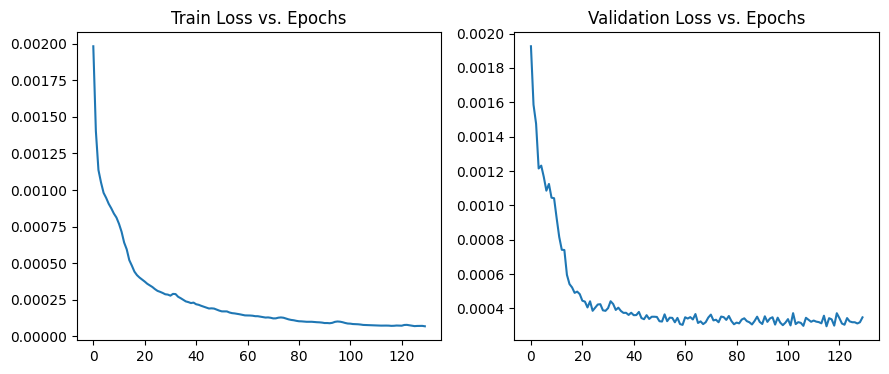

In [39]:
plt.figure(figsize=(4 * 4, 4))
tn_ls = plt.subplot(1, 3, 1)
plt.plot([i for i in range(len(train_loss))], torch.tensor(train_loss))
tn_ls.set_title("Train Loss vs. Epochs")
vl_ls = plt.subplot(1, 3, 2)
plt.plot([i for i in range(len(valid_loss))], torch.tensor(valid_loss))
vl_ls.set_title("Validation Loss vs. Epochs")
# acc = plt.subplot(1, 3, 3)
# plt.plot([i for i in range(len(accuracies))], torch.tensor(accuracies))
# acc.set_title("Classification Accuracy vs. Epochs")
# for i in range(10): 
#     test(test_loader, ff, loss_func, t, classify)


### Training
Our dataset is a modified version of the emoji dataset in which additional data has been added by horizontally flipping, rotating, brightening and darkening copies of each emoji image.  
  
Our architecture is a PyTorch convolutional neural network. For our encoder, in order to transform our data we use a sequence of 4 pairs of convolutonal layers + ReLU activation functions, followed by a flattening layer and a fully connected layer to condense our data into our latent embedding. For our decoder, we apply the reverse operations, beginning with a fully connected layer into an unflattening layer, follwed by a series of transpose convolutional layers and ReLU activation functions, and ending with a sigmoid function. In all convolutional layers, we use a kernel size of 4, a stride of 2, and a padding of 1.  
  
Our kernel size was chosen as 4 in order to capture finer details in the emoji images without making the network too computationally intensive. Padding and stride were both chosen according to the output sizes we were aiming for, as our choices allowed us to halve the size of our image with each convolutional layer. We decided that a bottleneck of 256 would be enough to sufficiently train the decoder to identify and translate more complex features, though we noticed little difference between latent embeddings of sizes 128 to 512. Our learning rate of 1e-3 was chosen as it was the largest learning rate that didn't prevent our model from learning anything. We chose an epoch of 130, because we noticed little improvement in our model's performance after this general point. 
  
Kernel size = 4, Stride = 2, Padding = 1, Loss Function = MSE, Learning Rate = 1e-3, and Epochs = 130.
  
\
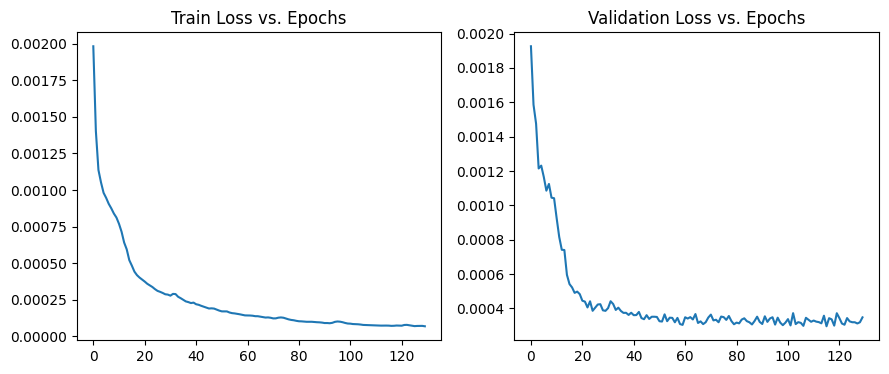 
  
Average Error = 0.000192
  
\
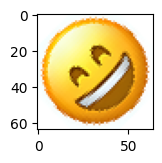 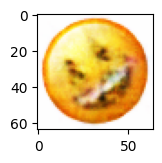 \
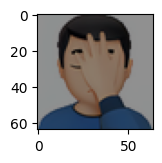 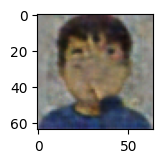\
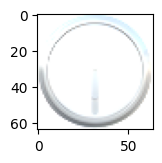 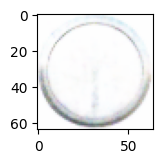 \
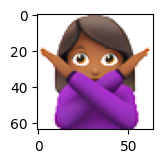 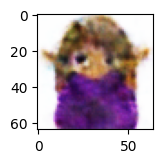 \
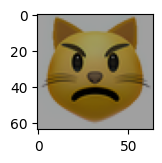 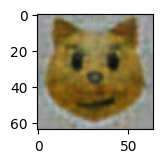 
  
We noticed from the loss graphs that the performance gains appear to drop off significantly after 80 or so epochs. This is reflected in the quality of the decoded images as more epochs are trained. It is worth noting that the model breaks down when decoding some more complex rotated images, most likely due to the randomness of the rotation angle in the training data. Otherwise, we believe that our model is successful, as the decoded images are generally identifiable as their original counterparts save for some noisy outliers.

### Classification
We separated our data into 5 different classes - Normal, Inanimate, Humanoid, Animal, and Human. Normal is a catch-all for the basic, stereotypical yellow emoji face. Human is reserved for emojis that depict more anatomically correct human faces. Humanoid is for images that are categorically between Normal and Human, such as the cat emojis and sun/moon faces. Finally, Animal and Inanimate self-explanitorily classify emojis that fit their respective categories. All of the classification was performed using key-word recognition, found by manually evaluating repeating themes/keywords that are present in many emojis that may fit one category.  
  
Our classifier uses gradient descent and cross entropy loss as components of its loss function within our autoencoder. As a result, both the decoding loss and classification loss are used to adjust the model weights at each training step. We ran this model using 130 epochs and a learning rate of 1e-3. For the encoder, we again used Kernel size = 4, Stride = 2, and Padding = 1.    
  
\
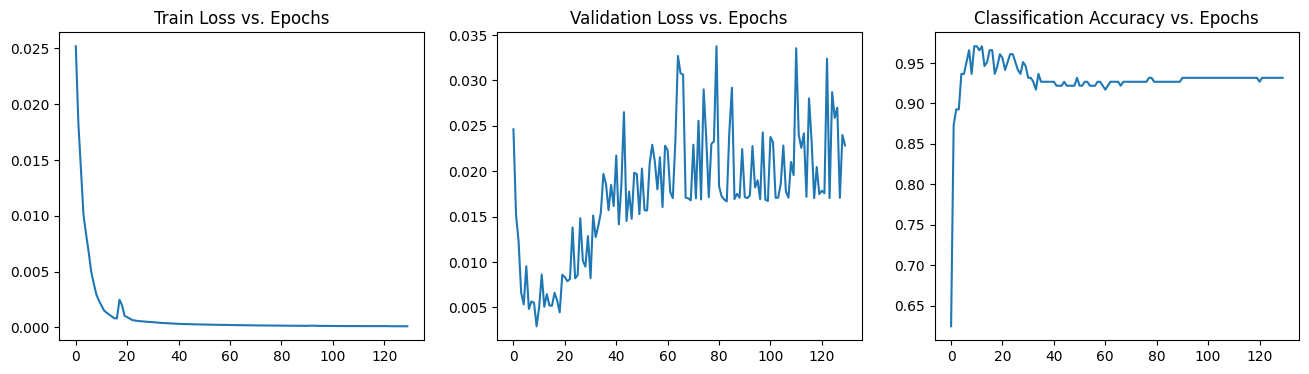  
  
\
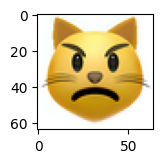 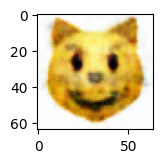 \
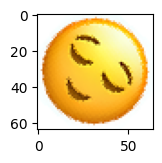 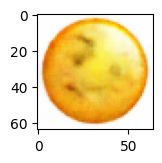 \
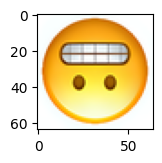 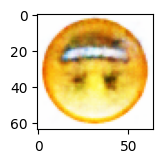 \
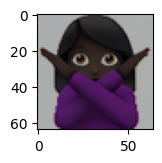 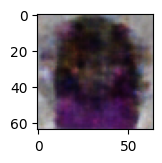 \
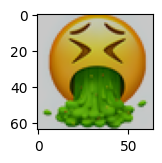 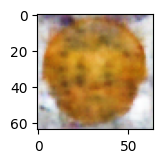   
  
Incorporating classification into our encoder appeared to worsen the quality of our encoder's output images. Some attributes were smoothed or scrambled compared to similar images when the model was run without any classification functionality.  
  
We suspect that performance changed due to conflation caused by the inclusion of an additional loss parameter. We believe that the difference in magnitudes between the different loss components may lead to the model fixating on improving at one task over the other. Furthermore, the resulting overall loss function most likely does not have a point that is reachable with gradient descent that can produce satisfactory results for both tasks at once. An experiment to confirm this would be to change the weight that one individual loss function has on the overall loss, with the hypothesis that lowering the weight of one task's loss would improve the model's performance with the other task.

In [8]:
# Save Weights and Latent Embeddings
torch.save(ff.state_dict(), 'model_weights.pth')

latent_reps = []
ff.eval()

for name, loader in [('train', train_loader), ('val', valid_loader), ('test', test_loader)]:
    latent_reps = []

    with torch.no_grad():
        for images, _ in loader:
            features = ff.encode(images)
            latent_reps.append(features)

    latent_reps = torch.cat(latent_reps, dim=0)
    torch.save(latent_reps, f'{name}_latent.pt')

610


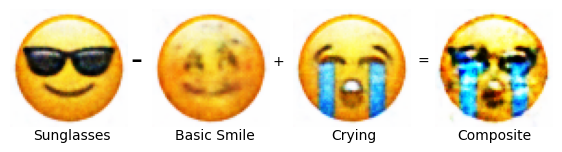

In [59]:
model = Encoder()
# Load Weights and Latent Embeddings
model.load_state_dict(torch.load('model_weights.pth'))
train_latent = torch.load('train_latent.pt')
val_latent = torch.load('val_latent.pt')
test_latent = torch.load('test_latent.pt')
model.eval()
# i = 0
# print(train_latent)
# for emoji in val_latent[i:]:
    
#     img = model.decode(emoji)
#     #print(img)
    
#     img = np.transpose(img.detach().numpy(), (2, 1, 0))
#     img = (img * 255).astype(np.uint8)
#     img = Image.fromarray(img)
#     plt.imshow(img)
#     plt.show()
#     print(i)
#     i += 1

smirk = (train_latent[525])
smile = val_latent[108]
sun = (train_latent[121])
conf = (train_latent[385])
plead = train_latent[170]
chill = train_latent[387]
sick = train_latent[498]
dev = train_latent[605]
bent = train_latent[557]
cry = train_latent[132]
print(len(train_latent))

# new_emoji = smirk
# new_emoji = sun
# new_emoji = sun - smirk + chill
new_emoji = sun - smile + cry
#new_emoji = sick + plead - sad
#print(new_emoji)

#print(img)

emojilist = [sun, smile, cry, new_emoji]
fig, ax = plt.subplot_mosaic([['start', 'minus', 'plus', 'result']], figsize = (7, 3.5))
i = 0
imglist = []
for emoji in emojilist:

    img = model.decode(emoji)
    img = np.transpose(img.detach().numpy(), (2, 1, 0))
    img = (img * 255).astype(np.uint8)
    img = Image.fromarray(img)
    imglist.append(img)
    # plt.imshow(img)
    # plt.show()
    i += 1
#print(i)
ax['start'].axis("off")
ax['minus'].axis("off")
ax['plus'].axis("off")
ax['result'].axis("off")
ax['start'].imshow(imglist[0])
ax['minus'].imshow(imglist[1])
ax['plus'].imshow(imglist[2])
ax['result'].imshow(imglist[3])
ax['start'].text(65, 32, "-", fontsize = 24)
ax['minus'].text(65, 30, "+")
ax['plus'].text(67, 30, "=")

ax['start'].text(12, 70, "Sunglasses")
ax['minus'].text(12, 70, "Basic Smile")
ax['plus'].text(20, 70, "Crying")
ax['result'].text(12, 70, "Composite")
plt.show() 



### Vector Arithmetic & Emoji Generation
We selected the glasses from the sunglasses emoji to compose with the crying emoji, hoping to create a crying emoji wearing sunglasses. We extracted the latent weights from our trained encoder model and performed rudimentary vector arithmetic operations to create a new weight vector that could then be fed into our decoder. The results are as follows:  
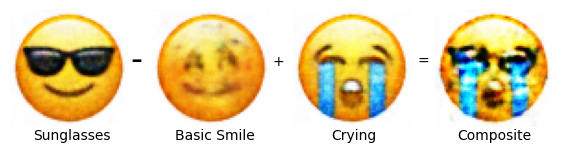  

Qualitatively, our resulting image is more noisy/grainy than its composite parts. It is harder to identify the relevant attributes, though the sunglasses, tears, and mouth are recognizable.

The quality of the image could be improved in a few ways - one would be to include some weight values to experiment with when doing our vector arithmetic, such as changing the equation from 1x - 1x + 1x to 2x -1.5x + 3x. Another method would be to try and improve the performance of our encoder, probably by adding more diverse and representative training data, so that the composite emojis and decoder are both more finely tuned.